In [19]:
from argparse import Namespace
import matplotlib.pyplot as plt
import numpy as np
import random
import pprint
import torch

In [22]:
# Arguments
args = Namespace(
    seed=1024,
    num_samples_per_class=500,
    dimensions=2,
    num_classes=3,
    train_size=0.75,
    test_size=0.25,
    num_hidden_units=500,
    learning_rate=1e-0,
    regularization=1e-3,
    num_epochs=200,
)

# Set seed for reproducability
np.random.seed(args.seed)
pprint.pprint(vars(args),indent = 4)

{   'dimensions': 2,
    'learning_rate': 1.0,
    'num_classes': 3,
    'num_epochs': 200,
    'num_hidden_units': 500,
    'num_samples_per_class': 500,
    'regularization': 0.001,
    'seed': 1024,
    'test_size': 0.25,
    'train_size': 0.75}


In [3]:
# Generate non-linear data
def generate_data(num_samples_per_class, dimensions, num_classes):
    # Make synthetic spiral data
    X_original = np.zeros((num_samples_per_class*num_classes, dimensions))
    y = np.zeros(num_samples_per_class*num_classes, dtype='uint8')
    for j in range(num_classes):
        ix = range(num_samples_per_class*j,num_samples_per_class*(j+1))
        r = np.linspace(0.0,1,num_samples_per_class) # radius
        t = np.linspace(j*4,(j+1)*4,num_samples_per_class) + \
        np.random.randn(num_samples_per_class)*0.25 # theta
        X_original[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j

    # Stack
    X = np.hstack([X_original])

    return X, y

In [4]:
# Generate X & y
X, y = generate_data(num_samples_per_class=args.num_samples_per_class, 
                     dimensions=args.dimensions, num_classes=args.num_classes)
print ("X: {0}".format(np.shape(X)))
print ("y: {0}".format(np.shape(y)))

X: (1500, 2)
y: (1500,)


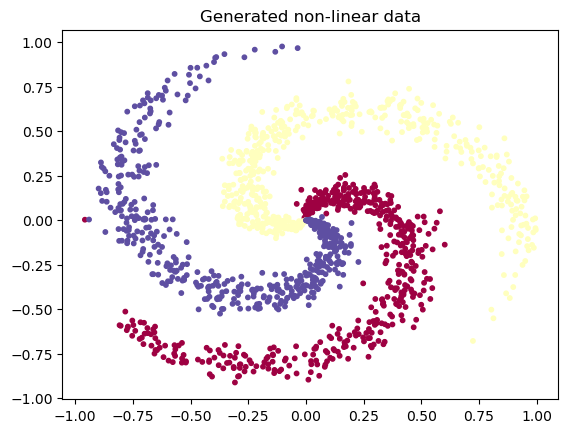

In [5]:
# Visualize data
plt.title("Generated non-linear data")
plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap=plt.cm.Spectral)
plt.show()

In [6]:
print(type(X),type(y))
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()
print(X.type(),y.type())

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
torch.FloatTensor torch.LongTensor


In [7]:
z = random.sample(range(0,len(X)),len(X))
s_index = torch.LongTensor(z)
X = X[s_index]
y = y[s_index]
test_index_s = int(len(X) * args.train_size)
print(test_index_s)
X_train = X[:test_index_s]
y_train = y[:test_index_s]
X_test = X[test_index_s:]
y_test = y[test_index_s:]
print("This case contians %i train samples and %i test samples" % (len(X_train), len(y_test)))

1125
This case contians 1125 train samples and 375 test samples


In [8]:
# test for a liner model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

In [9]:
class LogisticClassifier(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim):
        super(LogisticClassifier,self).__init__()
        self.fc1 = nn.Linear(input_dim,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,output_dim)

    def forward(self,x_in,apply_Softmax = False):
        a_1 = self.fc1(x_in)
        y_pred = self.fc2(a_1)

        if apply_Softmax :
            y_pred = F.softmax(y_pred,dim=1)

        return y_pred

In [10]:
model = LogisticClassifier(input_dim=args.dimensions, 
                           hidden_dim=args.num_hidden_units, 
                           output_dim=args.num_classes)
print (model.named_modules)

<bound method Module.named_modules of LogisticClassifier(
  (fc1): Linear(in_features=2, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=3, bias=True)
)>


In [11]:
loss_f = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = args.learning_rate)

In [12]:
def get_Accuracy(y_pred,y_target):
    n_correct = torch.eq(y_pred,y_target).sum().item()
    # how mant numbers about y_pred[element] == y_target[element]
    accuracy = n_correct / len(y_pred) * 100
    return accuracy

In [13]:
for t in range(args.num_epochs):
    y_pred = model(X_train)
    _,predictions = y_pred.max(dim = 1)#index of the max value of y_pred
    accuracy = get_Accuracy(y_pred=predictions.long(),y_target=y_train)
    loss = loss_f(y_pred,y_train)

    if t%10 == 0:
        print( " epoch: {0:02d} | loss: {1:.4f} | accuracy: {2:.1f}%".format(
            t, loss, accuracy
        )
             )
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

 epoch: 00 | loss: 1.1016 | accuracy: 46.2%
 epoch: 10 | loss: 140.0807 | accuracy: 54.6%
 epoch: 20 | loss: 79.8030 | accuracy: 57.0%
 epoch: 30 | loss: 65.0450 | accuracy: 24.3%
 epoch: 40 | loss: 16.3838 | accuracy: 50.5%
 epoch: 50 | loss: 17.2443 | accuracy: 32.8%
 epoch: 60 | loss: 9.9063 | accuracy: 32.7%
 epoch: 70 | loss: 2.9947 | accuracy: 45.3%
 epoch: 80 | loss: 2.4612 | accuracy: 52.2%
 epoch: 90 | loss: 1.9809 | accuracy: 58.1%
 epoch: 100 | loss: 1.1787 | accuracy: 58.2%
 epoch: 110 | loss: 0.9352 | accuracy: 55.6%
 epoch: 120 | loss: 0.7949 | accuracy: 53.1%
 epoch: 130 | loss: 0.7806 | accuracy: 52.1%
 epoch: 140 | loss: 0.7747 | accuracy: 52.4%
 epoch: 150 | loss: 0.7716 | accuracy: 51.3%
 epoch: 160 | loss: 0.7709 | accuracy: 52.0%
 epoch: 170 | loss: 0.7708 | accuracy: 51.6%
 epoch: 180 | loss: 0.7706 | accuracy: 51.8%
 epoch: 190 | loss: 0.7706 | accuracy: 51.6%


In [14]:
_,pred_train = model(X_train,apply_Softmax = True).max(dim = 1)
_,pred_test = model(X_test,apply_Softmax = True).max(dim = 1)

In [15]:
# Train and test accuracies
train_acc = get_Accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_Accuracy(y_pred=pred_test, y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

train acc: 51.7%, test acc: 49.6%


In [16]:
def plot_multiclass_decision_boundary(model,X,y):
    x_min = X[:,0].min()-0.1
    x_max = X[:,0].max() + 0.1
    y_min = X[:,1].min() - 0.1
    y_max = X[:,1].max() + 0.1
    xx,yy = np.meshgrid( np.linspace( x_min,x_max,101 ),np.linspace( y_min,y_max,101 ) )

    X_test = torch.from_numpy(np.c_[xx.ravel(),yy.ravel()]).float()
    y_pred = model(X_test,apply_Softmax = True)
    _,y_pred = y_pred.max(dim = 1)
    y_pred = y_pred.reshape(xx.shape)

    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    

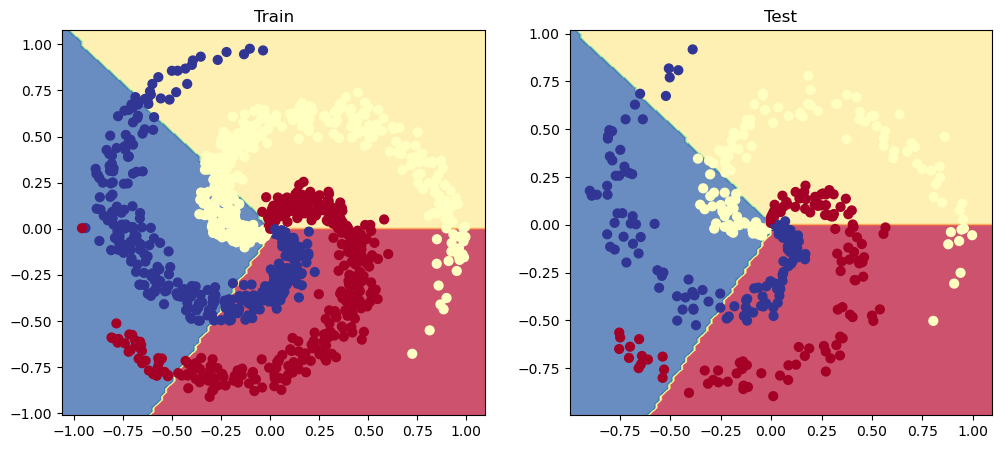

In [17]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()
